# Design robust Rydberg blockade two-qubit gates in cold atoms
**Using Boulder Opal to improve two-qubit controlled-Z gates for cold atoms**

Boulder Opal allows you to optimize and simulate a wide variety of controls for quantum systems. [Jaksch et al.](https://arxiv.org/pdf/quant-ph/0004038.pdf) proposed a scheme for the implementation of entangling gates that leverage the interaction between Rydberg states of neutral atoms. This interaction is very strong and results in a blockade effect that inhibits simultaneous excitation of adjacent atoms to a Rydberg state, enabling very fast generation of entanglement. [Saffman et al.](https://arxiv.org/pdf/1912.02977.pdf) have examined the use of adiabatic rapid passage (ARP) pulses to implement entangling controlled-Z (CZ) gates with robustness to laser intensity and detuning errors.

In this notebook, we demonstrate how Boulder Opal can be used to generate controls that extend this robustness by explicitly including it in the optimization, along with robustness to the decay of the Rydberg excited state. This strategy achieves both better best-case performance and greater robustness to noise than the adiabatic pulses.


## Imports and initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qctrlvisualizer as qv
import boulderopal as bo

bo.cloud.set_verbosity("QUIET")
plt.style.use(qv.get_qctrl_style())


controls_for_plots = lambda opt: {
    "$\\Omega$": opt["output"]["amplitude"],
    "$\\Delta$": opt["output"]["detuning"],
}


# Read and write helper functions, type independent.
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w+") as file:
        file.write(jsonpickle.encode(var))


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())

##  Hamiltonian model for the symmetric Rydberg controlled-Z gates

Our starting point is the Hamiltonian described by [Saffman et al.](https://arxiv.org/pdf/1912.02977.pdf) for the CZ gate:

$$ H(t) = H_c(t) \otimes \mathbb{1}_t +   \mathbb{1}_c \otimes H_t(t) + B \vert rr\rangle \langle rr \vert,$$
where $B$ is the blockade strength and the subscripts $c$, $t$ correspond to the control and target qubits, respectively. We will assume a global drive, meaning that the envelope for $H_c(t)$ and $H_t(t)$ are the same. Treating the atoms as a three-level system with hyperfine qubit states $\vert 0 \rangle$ and $\vert 1 \rangle$ and a Rydberg excited state $\vert r \rangle$, we can write $H_{c/t}$ as 

$$H_{c/t} = \left[\frac{\Omega(t)}{2} 
\vert r \rangle_{c/t} \langle 1 \vert + H.c. \right] + \Delta(t) \vert r\rangle_{c/t} \langle r\vert.
$$

The total Hamiltonian can then be written as

\begin{align*}H(t) = &\frac{\Omega(t)}{2}\Big(\vert 01 \rangle \langle 0r \vert + \vert 10 \rangle \langle r0 \vert + \vert 1r \rangle \langle rr \vert + \vert r1 \rangle \langle rr \vert + \vert 11 \rangle \langle 1r \vert + \vert 11 \rangle \langle r1 \vert + H.c\Big) \\&+ \Delta(t) \Big(\vert 0r \rangle \langle 0r \vert + \vert r0 \rangle \langle r0 \vert + \vert 1r \rangle \langle 1r \vert + \vert r1 \rangle \langle r1 \vert + 2 \vert rr \rangle \langle rr \vert \Big) + B \vert rr \rangle \langle rr \vert.\end{align*}

We aim to implement the CZ gate which, up to global single-qubit rotations, is given in the computational basis by

\begin{align*} U =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & e^{i\theta_s} & 0 & 0 \\
0 & 0 & e^{i\theta_s} & 0 \\
0 & 0 & 0 & e^{i(2\theta_s + \pi)}
\end{pmatrix},
\end{align*}
where $\theta_s$ is a free parameter. 

### CZ gate with adiabatic rapid passage (ARP) pulses
[Saffman et al.](https://arxiv.org/pdf/1912.02977.pdf) propose the implementation of the entangling CZ gate with a symmetric ARP pulse applied globally to both atomic qubits. This control sequence is characterized by an amplitude and detuning given, respectively, by

\begin{align*}
\Omega(t) &= \Omega_0 \left[\exp(-(t-t0)^4/\tau^4) - a\right] / (1 - a)\\
\Delta(t) &= - \Delta_0 \sin(2 \pi (t - t0)/T),
\end{align*}

where each pulse has total duration $T/2$, $a$ is set so the amplitude is zero at the start and end of the pulse, $t_0$ is the center of the pulse, and $\tau = 0.175T$. Two pulses are used in succession to implement the gate. In what follows, we will use these pulses as benchmarks for comparison with the solutions obtained using Boulder Opal.

## Gate optimization for finite blockade strength

The analytic ARP pulses defined above are capable of implementing the CZ operation with high fidelity with a strong blockade, however the gate infidelity grows as the blockade weakens, as we will see below. In this section, we show how to produce an optimized, band-limited control sequence with Boulder Opal that achieves high fidelity gates, even with weaker blockades, by accounting for the blockade strength. 

Let's start with the definition of operators and parameters for the system. In the cell below we consider the following pulse parameters used in [Saffman et al.](https://arxiv.org/pdf/1912.02977.pdf): 
\begin{align*}
\Omega_0/2\pi &= 17~{\rm MHz},\\
\Delta_0/2\pi &= 23~{\rm MHz},\\
T &= 540~{\rm ns}.
\end{align*}

In [2]:
# Set parameters.
Omega_0 = 17 * 2 * np.pi * 1e6  # rad/s
Delta_0 = 23 * 2 * np.pi * 1e6  # rad/s
duration = 540 * 1e-9  # s
cutoff_frequency = Omega_0
segment_count = 256
sample_times = np.linspace(0, duration, segment_count)

# Define system operators.
basis_labels = ["00", "01", "10", "11", "0r", "r0", "1r", "r1", "rr"]
drive_operator = np.zeros((9, 9))
drive_operator[([1, 2, 3, 3, 6, 7], [4, 5, 6, 7, 8, 8])] = 1

detuning_operator = np.diag([0, 0, 0, 0, 1, 1, 1, 1, 2])

blockade_operator = np.zeros((9, 9))
blockade_operator[8, 8] = 1

# Components for the CZ operator.
h_00 = np.zeros((9, 9))
h_00[0, 0] = 1
h_01 = np.zeros((9, 9))
h_01[1, 1] = 1
h_01[2, 2] = 1
h_11 = np.zeros((9, 9))
h_11[3, 3] = 1

We now define a function that optimizes the pulses to achieve the target CZ gate. For the ARP scheme only the single qubit phase $\theta_s$ is optimizable. 
For the general optimal pulse, the time dependence of $\Omega(t)$ and $\Delta(t)$ will be only constrained by the maximum value of the amplitudes of the pulses and by the imposition of bandwidth limits to generate smooth pulse envelopes.

In [3]:
# Graph for blockade strengths B in rad/s.
def optimize_cz_gate(
    pulse_scheme, blockade_strength, cost_node, optimization_count=10, **robustness
):
    graph = bo.Graph()
    tau = 0.175 * duration
    t0 = duration / 4
    a = np.exp(-((t0 / tau) ** 4))

    if pulse_scheme == "ARP":
        # Create the discretized ARP envelope.
        times = np.linspace(0, duration / 2, segment_count)
        amplitude = (
            Omega_0
            * (np.exp(-(((times - t0) / tau) ** 4)) - np.exp(-((t0 / tau) ** 4)))
            / (1 - a)
        )
        detuning = Delta_0 * np.sin(2 * np.pi * (times - t0) / duration)

        Omega = graph.pwc_signal(values=amplitude, duration=duration / 2)
        Delta = graph.pwc_signal(values=detuning, duration=duration / 2)

        # 2 pulses to implement the gate.
        Omega = graph.time_concatenate_pwc([Omega, Omega], name="amplitude")
        Delta = graph.time_concatenate_pwc([Delta, Delta], name="detuning")

    else:
        opt_var_count = 20
        flat_gaussian_envelope = graph.signals.gaussian_pulse_pwc(
            duration=duration,
            segment_count=segment_count,
            amplitude=1,
            flat_duration=duration * 0.9,  # s
        )
        amplitude = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count, maximum=Omega_0, duration=duration
        )
        detuning = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count,
            maximum=Delta_0,
            minimum=-Delta_0,
            duration=duration,
        )
        Omega = graph.filter_and_resample_pwc(
            amplitude,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Omega = Omega * flat_gaussian_envelope
        Omega.name = "amplitude"
        Delta = graph.filter_and_resample_pwc(
            detuning,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Delta = Delta * flat_gaussian_envelope
        Delta.name = "detuning"

    # Create Hamiltonian.
    drive_term = graph.hermitian_part(Omega * drive_operator)
    delta_term = Delta * detuning_operator
    blockade_term = blockade_strength * blockade_operator
    hamiltonian = drive_term + delta_term + blockade_term

    # Single-qubit rotation is a free parameter, can be optimized for best fidelity.
    theta_s = graph.optimizable_scalar(
        lower_bound=0.0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
        name="theta_s",
    )

    # Define target operation.
    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)

    # Define noise list to include robustness.
    noise_list = []
    if robustness["dephasing"]:
        noise_list.append(detuning_operator / duration)
    if robustness["amplitude"]:
        noise_list.append(drive_term)
    penalty = robustness["decay"]

    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=target,
        noise_operators=noise_list,
        name="infidelity",
    )

    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times, name="unitary"
    )

    # Node to store blockade value used (in Hz).
    blockade = graph.abs(blockade_strength / 2 / np.pi)
    blockade.name = "blockade"

    decay_cost = graph.sum(
        graph.abs(unitary[:, 4, 1]) ** 2
        + graph.abs(unitary[:, 5, 2]) ** 2
        + graph.abs(unitary[:, 6, 3]) ** 2
        + graph.abs(unitary[:, 7, 3]) ** 2
        + 2 * graph.abs(unitary[:, 8, 3]) ** 2
    ) * (0.25 * sample_times[1] / sample_times[-1])

    decay_cost.name = "decay cost"

    cost = graph.log(infidelity + penalty * decay_cost, name="cost")

    result = bo.run_optimization(
        graph=graph,
        output_node_names=[
            "theta_s",
            "amplitude",
            "detuning",
            "unitary",
            "infidelity",
            "blockade",
            "decay cost",
        ],
        cost_node_name=cost_node,
        optimization_count=optimization_count,
    )

    return result

As an example, let's create a standard ARP pulse and calculate the gate infidelity using the function above for a given value of the blockade ($B = 2.5~{\rm GHz}$ in this case).

In [4]:
result_arp = optimize_cz_gate(
    pulse_scheme="ARP",
    blockade_strength=2.5e9 * 2 * np.pi,
    cost_node="infidelity",
    dephasing=False,
    amplitude=False,
    decay=0.0,
)
print("Gate infidelity is", f"{result_arp['output']['infidelity']['value']:.3e}")
print("Single-qubit phase is", f"{result_arp['output']['theta_s']['value']:.3f}")

Gate infidelity is 2.083e-04
Single-qubit phase is 3.167


We can see that in the absence of noise, the gate infidelity is quite low, about $2\times10^{-4}$. We can also plot the controls used for the gate implementation.

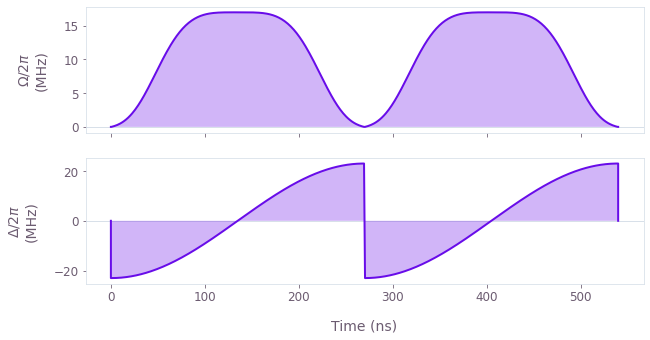

In [5]:
qv.plot_controls(controls_for_plots(result_arp), smooth=True)

For the general optimal pulse in the absence of noise we see an improvement of the gate infidelity by several orders of magnitude. The controls used for the optimal pulse are also shown here.

Gate infidelity is 3.371e-10
Single-qubit phase is 1.868


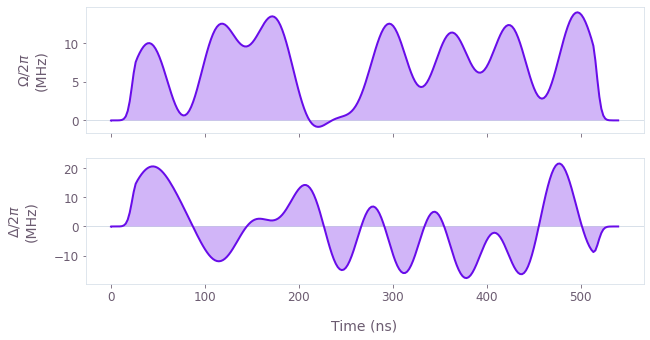

In [6]:
opt_result = optimize_cz_gate(
    pulse_scheme="opt",
    blockade_strength=2.5e9 * 2 * np.pi,
    cost_node="infidelity",
    dephasing=False,
    amplitude=False,
    decay=0.0,
)
print("Gate infidelity is", f"{opt_result['output']['infidelity']['value']:.3e}")
print("Single-qubit phase is", f"{opt_result['output']['theta_s']['value']:.3f}")
qv.plot_controls(controls_for_plots(opt_result), smooth=True)

### CZ gate infidelity for varying blockade strength

For the two pulse schemes (ARP and optimal), we can optimize the gate and measure the resulting infidelity for varying blockade strengths. The optimal pulse outperforms the ARP pulse by several orders of magnitude for every blockade strength, including in the low blockade region where the ARP infidelity increases.

In [7]:
# Vary blockade strength from 250 MHz to 4 GHz.
blockades = 2 * np.pi * 1e6 * np.array([250, 500, 1750, 2500, 4000])

blockade_scan_results = {}
with bo.cloud.group_requests():
    blockade_scan_results["ARP"] = [
        optimize_cz_gate(
            "ARP",
            B,
            cost_node="infidelity",
            dephasing=False,
            amplitude=False,
            decay=0.0,
        )
        for B in blockades
    ]
    blockade_scan_results["Optimal, non-robust"] = [
        optimize_cz_gate(
            "optimal",
            B,
            cost_node="infidelity",
            dephasing=False,
            amplitude=False,
            decay=0.0,
        )
        for B in blockades
    ]

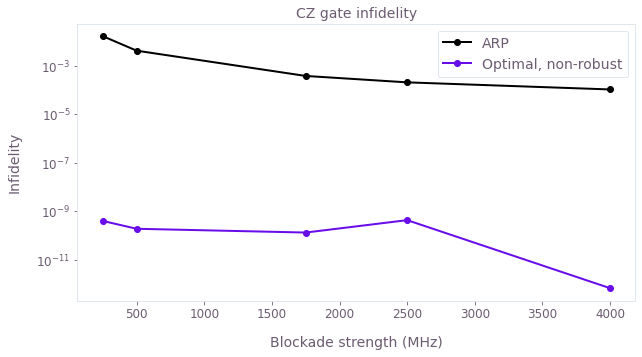

In [8]:
color_plot = {"ARP": "k", "Optimal, non-robust": qv.QCTRL_STYLE_COLORS[0]}
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for scheme, results in blockade_scan_results.items():
    ax.plot(
        blockades / (2 * np.pi * 1e6),
        np.array([opt["output"]["infidelity"]["value"] for opt in results]),
        marker="o",
        label=scheme,
        c=color_plot[scheme],
    )
ax.set_xlabel("Blockade strength (MHz)")
ax.set_ylabel("Infidelity")
ax.set_yscale("log")
ax.legend(loc="best", bbox_to_anchor=(1, 1))
ax.set_title("CZ gate infidelity")
plt.show()

## Characterizing susceptibility to noise

Now we will investigate the susceptibility of these solutions to dephasing and noise in the control amplitudes. For this, the detuning and intensity errors are treated as quasi-static coherent error terms in the Hamiltonian during the gate, with the transformations:

\begin{align*}
\Delta &\rightarrow \Delta + \delta\Delta \\
\Omega(t) &\rightarrow \Omega(t) (1 + \delta \Omega).
\end{align*}

Note that the amplitude error is treated as a relative error rather than a constant offset. To evaluate the control performance in the presence of noise, we will fix the blockade strength at two different values and scan over different values of the noise while calculating the corresponding gate infidelity. For the coherent dynamics considered so far, calculations can be efficiently performed using Boulder Opal by creating a batch of Hamiltonians that can run in parallel. 

In [9]:
# Indices in the list of blockades for the chosen values.
B_indices = [0, -2]

# Defining the error ranges for the scan.
scan_point_count = 61
detuning_error_values = (
    np.linspace(-0.2, 0.2, num=scan_point_count) * 2 * np.pi * 1e6
)  # rad/s
amplitude_error_values = np.linspace(-0.3, 0.3, num=scan_point_count)

# Define control list.
control_list = [
    results[B_idx] for B_idx in B_indices for results in blockade_scan_results.values()
]


def run_coherent_simulation(
    control_results, detuning_error_values, amplitude_error_values
):
    graph = bo.Graph()

    # Get blockade value
    B = control_results["output"]["blockade"]["value"] * 2 * np.pi

    # Get pulse values
    Omega = graph.pwc(**control_results["output"]["amplitude"])
    Delta = graph.pwc(**control_results["output"]["detuning"])

    detuning_error = graph.constant_pwc(
        constant=detuning_error_values[:, None, None],
        duration=duration,
        batch_dimension_count=2,
    )
    amplitude_error = graph.constant_pwc(
        constant=amplitude_error_values[None, :, None],
        duration=duration,
        batch_dimension_count=2,
    )

    # add noise to the hamiltonian
    hamiltonian = (
        graph.hermitian_part(Omega * (1.0 + amplitude_error) * drive_operator)
        + (Delta + detuning_error) * detuning_operator
        + B * blockade_operator
    )

    theta_s = control_results["output"]["theta_s"]["value"]

    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)

    infid = graph.infidelity_pwc(
        hamiltonian=hamiltonian, target=target, name="infidelity"
    )

    result = bo.execute_graph(graph, "infidelity")

    return result

In [10]:
# Run the dephasing/amplitude error scans for ARP pulse.
with bo.cloud.group_requests():
    infidelity_scan = [
        run_coherent_simulation(control, detuning_error_values, amplitude_error_values)
        for control in control_list
    ]

# Extracting scan results.
error_scan = {}
idx = 0
for B_idx in B_indices:
    scan_per_scheme = {}
    for scheme in blockade_scan_results.keys():
        scan_per_scheme[scheme] = infidelity_scan[idx]["output"]["infidelity"]["value"]
        idx += 1
    error_scan[B_idx] = scan_per_scheme

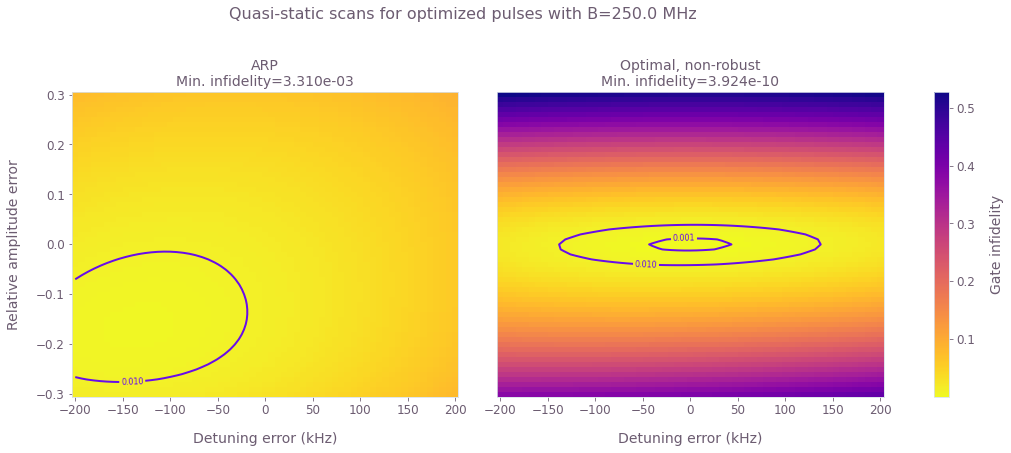

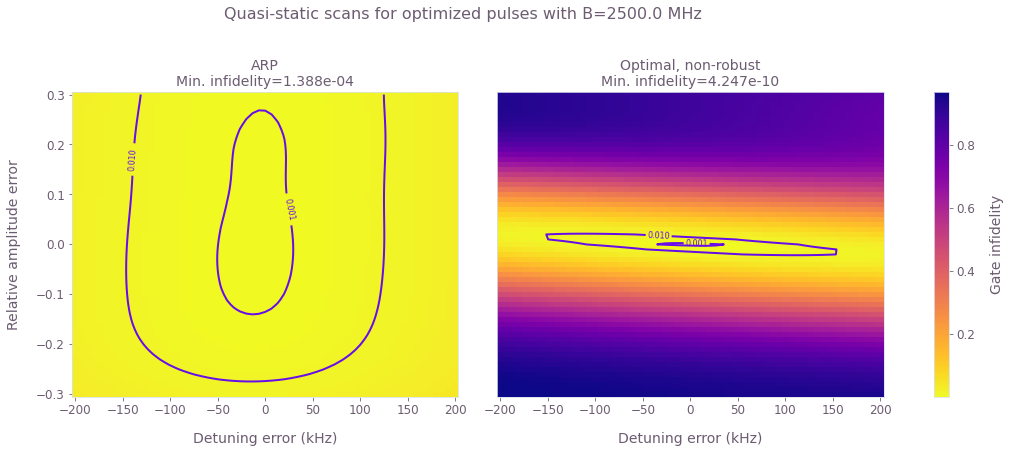

In [11]:
for B_idx, scan in error_scan.items():
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    fig.suptitle(
        f"Quasi-static scans for optimized pulses with B={blockades[B_idx]/2/np.pi/1e6} MHz",
        y=1.18,
        x=0.4,
    )

    all_min = np.min([inf for inf in scan.values()])
    all_max = np.max([inf for inf in scan.values()])

    for idx, (scheme, infidelity) in enumerate(scan.items()):
        axs[idx].set_title(
            scheme + "\n" + "Min. infidelity=" + f"{np.min(infidelity):.3e}"
        )
        c = axs[idx].pcolormesh(
            detuning_error_values / (2 * np.pi * 1e3),
            amplitude_error_values,
            infidelity.squeeze().T,
            vmin=all_min,
            vmax=all_max,
            cmap=plt.colormaps["plasma"].reversed(),
        )
        contours = axs[idx].contour(
            detuning_error_values / (2 * np.pi * 1e3),
            amplitude_error_values,
            infidelity.squeeze().T,
            levels=[0.001, 0.01],
            colors="#680CEA",
        )
        axs[idx].set_xlabel("Detuning error (kHz)")
        plt.clabel(contours, inline=True, fontsize=8)
        if idx != 0:
            axs[idx].set_yticks([])
    cbar = fig.colorbar(c, ax=axs, label="Gate infidelity")

    axs[0].set_ylabel("Relative amplitude error")
    plt.show()
    print("\n")

These results show that the ARP pulse shows some robustness to detuning and amplitude errors for large values of the blockade strength. The optimized pulse shows a strong robustness against dephasing for both values of blockade, even though this was not enforced in the optimization.  

## Designing robust CZ gates

In the previous sections, we saw that one can achieve orders of magnitude improvement in gate infidelity when pulses are optimized for different values of the blockade strength. The optimized pulses also show robustness against detuning errors. Now we will design pulses to include robustness against noise in the control amplitude. Note that the optimization function defined in the previous section already allows for designing such pulses by simply setting the values in the robustness dictionary to `True`.

We will choose two values for the Blockade strength (250 MHz and 2.5 GHz) and for each, find optimal pulses robust to amplitude noise. 

In [12]:
robustness_options = [{"dephasing": False, "amplitude": True, "decay": 0}]

with bo.cloud.group_requests():
    robust_controls = [
        optimize_cz_gate(
            pulse_scheme="robust",
            blockade_strength=blockades[B_idx],
            cost_node="infidelity",
            dephasing=robustness["dephasing"],
            amplitude=robustness["amplitude"],
            decay=robustness["decay"],
        )
        for B_idx in B_indices
        for robustness in robustness_options
    ]

# Storing scan results in a dictionary.
scheme_list = ["Amplitude robust"]
robust_controls_dic = {key: {} for key in scheme_list}
idx = 0
for B_idx in B_indices:
    scan_per_scheme = {}
    for scheme in scheme_list:
        robust_controls_dic[scheme].update({B_idx: robust_controls[idx]})
        idx += 1

### Comparing ARP with amplitude robust pulse

Now we will characterize the robust pulses by scanning over different values different values of the noise and calculating the resulting gate infidelity. Then we can compare the robust pulse with the original ARP pulse and the optimized pulse of the previous section by plotting the quasi-static scans for detuning and amplitude errors independently. 

In [13]:
# Run the scans.
with bo.cloud.group_requests():
    infidelity_scan = [
        run_coherent_simulation(control, detuning_error_values, amplitude_error_values)
        for control in robust_controls
    ]

# Extracting scan results.
robust_error_scan = {}
idx = 0
for B_idx in B_indices:
    scan_per_scheme = {}
    for scheme in scheme_list:
        scan_per_scheme[scheme] = infidelity_scan[idx]["output"]["infidelity"]["value"]
        idx += 1
    robust_error_scan[B_idx] = scan_per_scheme

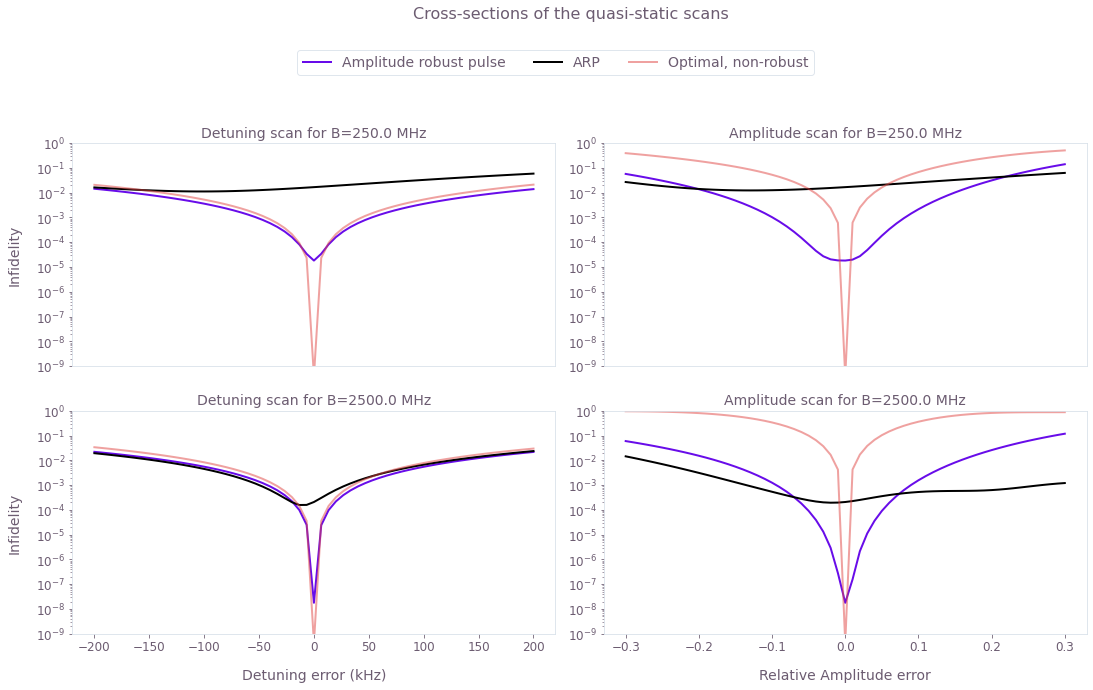

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle(f"Cross-sections of the quasi-static scans", y=1.15)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.2)
for idx, B_idx in enumerate(B_indices):
    ax[idx][0].set_title(f"Detuning scan for B={blockades[B_idx]/2/np.pi/1e6} MHz")
    ax[idx][1].set_title(f"Amplitude scan for B={blockades[B_idx]/2/np.pi/1e6} MHz")
    ax[idx][0].plot(
        detuning_error_values / 2 / np.pi / 1e3,
        robust_error_scan[B_idx]["Amplitude robust"][:, 30],
        label="Amplitude robust pulse",
    )
    ax[idx][0].plot(
        detuning_error_values / 2 / np.pi / 1e3,
        error_scan[B_idx]["ARP"][:, 30],
        label="ARP",
        c="k",
    )
    ax[idx][0].plot(
        detuning_error_values / 2 / np.pi / 1e3,
        error_scan[B_idx]["Optimal, non-robust"][:, 30],
        label="Optimal, non-robust",
        alpha=0.5,
    )
    ax[idx][1].plot(
        amplitude_error_values,
        robust_error_scan[B_idx]["Amplitude robust"][30, :],
        label="Amplitude robust pulse",
    )
    ax[idx][1].plot(
        amplitude_error_values, error_scan[B_idx]["ARP"][30, :], label="ARP", c="k"
    )

    ax[idx][1].plot(
        amplitude_error_values,
        error_scan[B_idx]["Optimal, non-robust"][30, :],
        label="Optimal, non-robust",
        alpha=0.5,
    )

    ax[idx][0].set_ylabel("Infidelity")
    ax[0][idx].set_xticks([])
for a in ax.ravel():
    a.set_yscale("log")
    a.set_ylim(1e-9, 1e-0)
ax[1][0].set_xlabel("Detuning error (kHz)")
ax[1][1].set_xlabel("Relative Amplitude error")
ax[0][0].legend(loc="best", bbox_to_anchor=(1.55, 1.45), ncol=3)
plt.show()

The optimized pulse outperforms the ARP pulse in both overall gate infidelity and in robustness against dephasing for both values of $B$. The robust optimized pulse also provides infidelities orders of magnitude smaller than the ones achieved with ARP pulses for a range of amplitude noise that increases for smaller blockade strength.

### Effects of spontaneous emission

We will now investigate the effect of spontaneous emission on gate performance using the pulses from the previous sections. The decay of the Rydberg state is an incoherent process, and so to simulate it we use the Lindblad master equation
$$
\partial_t \rho = -i [H(t), \rho] + \sum_{l,j} L^{(l)}_j \rho L^{(l)\dagger}_j - \frac{1}{2} \{L^{(l)\dagger}_jL^{(l)}_j, \rho \},
$$
where $l$ is an index over the two atoms and $L^{(l)}_j = \sqrt{b_{jr}\gamma_r}\vert j \rangle_l \langle r \vert$ is a decay operator between the Rydberg state and the state $\vert j \rangle \in \{ \vert 0 \rangle, \vert 1 \rangle, \vert d \rangle \}$. $\gamma_r$ is the decay rate of the Rydberg state, $b_{jr}$ are branching ratios between the three lower levels and $\vert d \rangle$ is a "dark" state that represents hyperfine levels not used to encode the qubit. [Saffman et al.](https://arxiv.org/pdf/1912.02977.pdf) take $\gamma_r = 1 / (540~{\rm \mu s})$, $b_{0r} = b_{1r} = 1/16$ and $b_{dr} = 7/8$.

To assess robustness of our pulses, we simulate the master equation using the initial state
$$
\vert \psi_0 \rangle = ((\vert 0 \rangle - \vert 1 \rangle)/\sqrt{2}) \otimes^2.
$$
Ideally, applying a CZ gate to this state will produce a maximally-entangled state, equivalent to a Bell state up to single-qubit rotations. We can quantify the error in the gate operation by taking the overlap of the final state with the target entangled state,
$$
\mathcal{F} = \langle \psi_t \vert \rho_f \vert \psi_t \rangle
$$
with
$$
\vert \psi_t \rangle = \frac{1}{2} (\vert 00 \rangle - e^{i\theta_s}(\vert 01 \rangle + \vert 10 \rangle) - e^{2i\theta_s}\vert 11 \rangle).
$$
This is equivalent to the Bell state fidelity used in the paper, assuming that single-qubit operations can be performed perfectly.

To evaluate the gate performance in the presence of decay, we define a function that simulates the open quantum system with a spontaneous emission term. The function below takes values of relative intensity error and detuning error, and returns a graph that simulates the master equation for those values and calculates the Bell state infidelity.

In [15]:
gamma_r = 1 / (540e-6)  # 1/s, Rydberg decay rate.


def run_decay_simulation(detuning_error, amplitude_error, control_results):
    # Each atom is a four-level system: |0>, |1>, |r> and |d>.
    graph = bo.Graph()

    B = control_results["output"]["blockade"]["value"] * 2 * np.pi

    # Define operators and drive for one atom.
    drive_operator = np.zeros((4, 4))
    drive_operator[1, 2] = 1

    detuning_operator = np.zeros((4, 4))
    detuning_operator[2, 2] = 1

    Omega = graph.pwc(**control_results["output"]["amplitude"])
    Delta = graph.pwc(**control_results["output"]["detuning"])

    # Define blockade term.
    blockade_operator = np.zeros((16, 16))
    blockade_operator[10, 10] = B

    # Define control Hamiltonian.
    drive_1 = graph.embed_operators((drive_operator, 0), [4, 4])
    drive_2 = graph.embed_operators((drive_operator, 1), [4, 4])
    detuning_1 = graph.embed_operators((detuning_operator, 0), [4, 4])
    detuning_2 = graph.embed_operators((detuning_operator, 1), [4, 4])

    hamiltonian = (
        graph.hermitian_part(Omega * (1.0 + amplitude_error) * (drive_1 + drive_2))
        + (Delta + detuning_error) * (detuning_1 + detuning_2)
        + blockade_operator
    )

    # Defin single atom decay operators.
    decay_states = [0, 1, 3]  # (0, 1, d states)
    branching_ratios = [1 / 16, 1 / 16, 7 / 8]
    Ls_single = []
    for decay_state, branching_ratio in zip(decay_states, branching_ratios):
        L = np.zeros((4, 4))
        L[decay_state, 2] = 1
        Ls_single.append((branching_ratio * gamma_r, L))

    # Lindblad terms for both atoms.
    Ls = [
        (gamma, graph.embed_operators([(L_single, atom)], [4, 4]))
        for atom in range(2)
        for gamma, L_single in Ls_single
    ]

    # Initial two-atom density matrix for simulation.
    qubit_initial = np.array([1, -1, 0, 0]) / np.sqrt(2)
    initial_state = np.kron(qubit_initial, qubit_initial)[:, None]
    initial_rho = initial_state @ initial_state.T.conj()

    # Simulate the master equation.
    evolved_state = graph.density_matrix_evolution_pwc(
        initial_density_matrix=initial_rho,
        hamiltonian=hamiltonian,
        lindblad_terms=Ls,
        name="evolved state",
    )

    theta_s = control_results["output"]["theta_s"]["value"]

    target_state = np.zeros(16, dtype=complex)
    target_state[0] = 0.5
    target_state[1] = -0.5 * np.exp(1j * theta_s)
    target_state[4] = -0.5 * np.exp(1j * theta_s)
    target_state[5] = -0.5 * np.exp(2j * theta_s)
    target_state = target_state[:, None]

    bell_state_infidelity = 1 - target_state.T.conj() @ evolved_state @ target_state
    bell_state_infidelity = graph.abs(bell_state_infidelity[0, 0])
    bell_state_infidelity.name = "infidelity"

    result = bo.execute_graph(graph, ["evolved state", "infidelity"])

    return result

We will now show how Boulder Opal can be used to produce a control pulse that is designed to be robust to intensity and detuning errors, as well as decay of the Rydberg state. Directly including the decay in a master equation simulation during the optimization would be very computationally expensive, so we instead add a cost term to the infidelity, which integrates the population of the Rydberg state during the gate. This cost term is given by
$$
C = \frac{1}{4} \int \Big( |U(t)_{0r,01}|^2 + |U(t)_{1r,11}|^2 + |U(t)_{r1,11}|^2 + 2 |U(t)_{rr,11}|^2 \Big) \mathrm{d}t.
$$
This cost is already included in the `optimize_cz_gate` function defined at the beginning of this notebook. To enable this term, we just need to input a non-zero penalty as the value of `decay` key in the robustness dictionary. In the next cell we run an optimization with this decay option.

In [16]:
decay_robust_control = {}
for B_idx in B_indices:
    decay_robust_control[B_idx] = optimize_cz_gate(
        pulse_scheme="amplitude robust",
        blockade_strength=blockades[B_idx],
        cost_node="cost",
        dephasing=False,
        amplitude=True,
        decay=0.05,
    )

We will now choose a range for each error source and execute the simulations for three different pulses: ARP, amplitude robust, and amplitude robust with decay mitigation.

In [17]:
# Defining the error ranges for the scan.
scan_point_count = 15
error_values = {
    "Detuning": np.linspace(-0.2, 0.2, num=scan_point_count) * 2 * np.pi * 1e6,
    "Amplitude": np.linspace(-0.3, 0.3, num=scan_point_count),
}

decay_results = {}

for B_idx in B_indices:
    # Define control list.
    controls = {
        "ARP": blockade_scan_results["ARP"][B_idx],
        "Amplitude robust": robust_controls_dic["Amplitude robust"][B_idx],
        "Amplitude robust with decay mitigation": decay_robust_control[B_idx],
    }

    # Detuning scan.
    results = {"Detuning": {}, "Amplitude": {}}
    for scheme, control in controls.items():
        simulations = []
        with bo.cloud.group_requests():
            for detuning_error in error_values["Detuning"]:
                simulations.append(run_decay_simulation(detuning_error, 0, control))
        infidelities = [s["output"]["infidelity"]["value"] for s in simulations]
        results["Detuning"][scheme] = np.array(infidelities)

    # Amplitude scan.
    for scheme, control in controls.items():
        simulations = []
        with bo.cloud.group_requests():
            for amplitude_error in error_values["Amplitude"]:
                simulations.append(run_decay_simulation(0, amplitude_error, control))
        infidelities = [s["output"]["infidelity"]["value"] for s in simulations]
        results["Amplitude"][scheme] = np.array(infidelities)

    decay_results[B_idx] = results

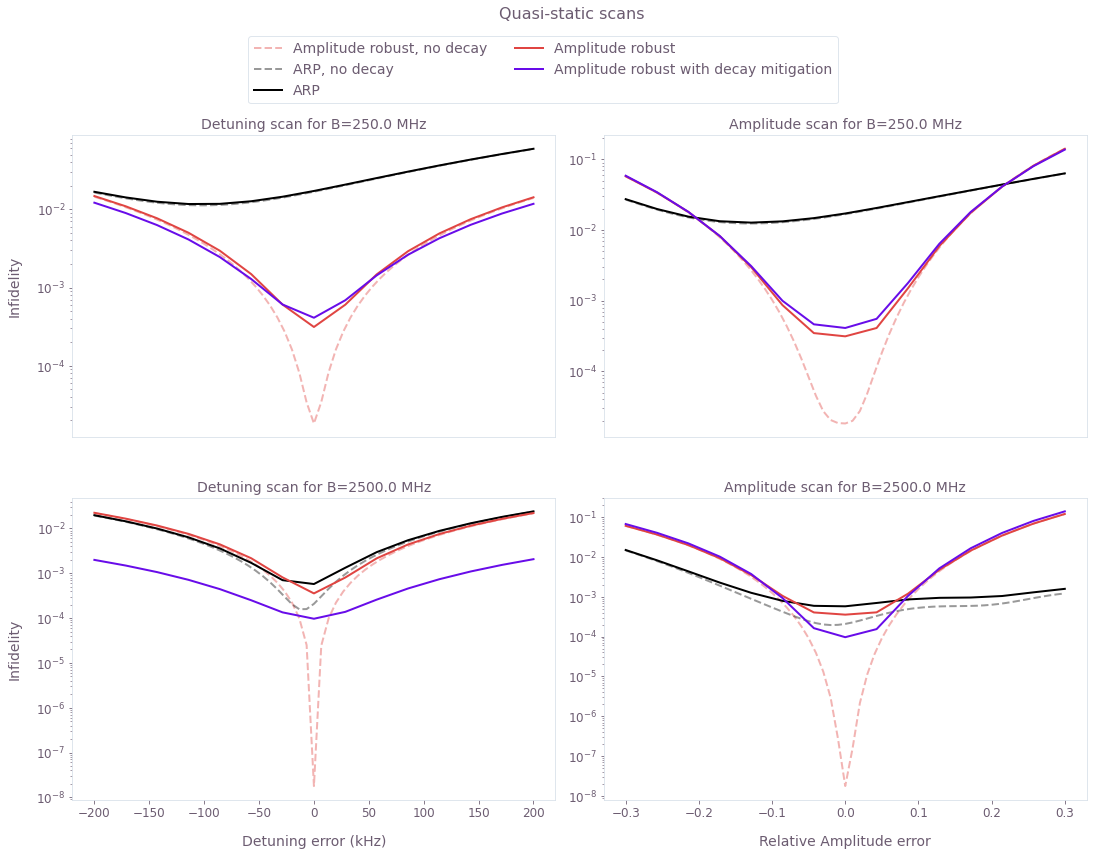

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.2)
fig.suptitle(f"Quasi-static scans", y=1.15)
color_plot = {
    "ARP": "k",
    "Amplitude robust": qv.QCTRL_STYLE_COLORS[1],
    "Dual robust": qv.QCTRL_STYLE_COLORS[2],
    "Optimal": qv.QCTRL_STYLE_COLORS[3],
    "Amplitude robust with decay mitigation": qv.QCTRL_STYLE_COLORS[0],
}
error_values["Detuning"] = error_values["Detuning"] / 2 / np.pi / 1e3
for idx, (B_idx, all_controls) in enumerate(decay_results.items()):
    ax[idx][0].plot(
        np.linspace(-0.2, 0.2, num=61) * 1e3,
        robust_error_scan[B_idx]["Amplitude robust"][:, 30],
        label="Amplitude robust, no decay",
        ls="--",
        c=color_plot["Amplitude robust"],
        alpha=0.4,
    )
    ax[idx][1].plot(
        np.linspace(-0.3, 0.3, num=61),
        robust_error_scan[B_idx]["Amplitude robust"][30, :],
        label="Amplitude robust, no decay",
        ls="--",
        c=color_plot["Amplitude robust"],
        alpha=0.4,
    )
    ax[idx][0].plot(
        np.linspace(-0.2, 0.2, num=61) * 1e3,
        error_scan[B_idx]["ARP"][:, 30],
        label="ARP, no decay",
        ls="--",
        c=color_plot["ARP"],
        alpha=0.4,
    )
    ax[idx][1].plot(
        np.linspace(-0.3, 0.3, num=61),
        error_scan[B_idx]["ARP"][30, :],
        label="ARP, no decay",
        ls="--",
        c=color_plot["ARP"],
        alpha=0.4,
    )
    ax[idx][0].set_ylabel("Infidelity")

    for idx2, (scan_name, control_results) in enumerate(all_controls.items()):
        ax[idx][idx2].set_title(
            scan_name + f" scan for B={blockades[B_idx]/2/np.pi/1e6} MHz"
        )
        for control_type, control in control_results.items():
            ax[idx][idx2].plot(
                error_values[scan_name],
                control.T,
                label=control_type,
                c=color_plot[control_type],
            )
        ax[0][idx2].set_xticks([])

ax[1][0].set_xlabel("Detuning error (kHz)")
ax[1][1].set_xlabel("Relative Amplitude error")
for a in ax.ravel():
    a.set_yscale("log")
ax[0][0].legend(loc="best", bbox_to_anchor=(1.6, 1.35), ncol=2)
plt.show()

The plot shows a decrease in the Bell state fidelity when decay is taken into account. This effect is stronger for higher blockade. 

The robust pulse with decay mitigation outperforms the ARP for the detuning range considered and by a factor of $\approx 20$ for the best infidelity. The ARP pulse is already quite robust against amplitude errors but the robust pulse with decay mitigation outperforms it roughly in the same region as in the no-decay case.